In [208]:
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import soundfile as sf
import pickle
from pydub import AudioSegment
from pydub.playback import play
import IPython.display as ipd
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, 
    PitchShift, Shift, ClippingDistortion, 
    FrequencyMask, TimeMask, Normalize
)
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

In [2]:
k = os.listdir(os.path.abspath('../../spotter_data/_background_noise_'))

In [4]:
df_target = pd.read_csv(os.path.abspath('Target_words_dataframe'))
df_unknown = pd.read_csv(os.path.abspath('Unknown_words_dataframe'))
df = pd.read_csv(os.path.abspath('full_df'))

In [5]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [6]:
def load_background(background_folder):
    background_noises = os.listdir(background_folder)
    noise_to_data = {}
    for noise in background_noises:
        data, sr = librosa.load(background_folder + '/' + noise)
        noise_to_data[noise] = data
    return noise_to_data

In [7]:
def pick_background_folder(background_folder):
    background_noises = os.listdir(background_folder)
    return random.choice(background_noises)

In [8]:
def get_background_segment(background_data, noise_len):
    start_ms = 0
    while True:
        ind = random.choice(range(0, len(background_data)))
        if ind + noise_len < len(background_data):
            return background_data[ind: ind + noise_len] 

In [9]:
def insert_background(background_folder, noise_to_data, wav_data, len_data):
    background_name = pick_background_folder(background_folder)
    background_data = noise_to_data[background_name]
    noise = get_background_segment(background_data, len_data)
    if background_name == 'pink_noise.wav' or background_name == 'white_noise.wav':
        wav_data = 10 * wav_data + noise
    else:
        wav_data = 4 * wav_data + noise
    return wav_data

In [14]:
def make_aug(wav_data, sr, background_folder, noise_to_data, len_data, p_aug):
    augment_gaussian_noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=p_aug['gaussian'])])
    augment_for_word = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.5, p=p_aug['stretch']),
        PitchShift(min_semitones=-6, max_semitones=6, p=p_aug['pitch_shift']),
        Shift(min_fraction=-0.3, max_fraction=0.3, p=p_aug['shift']),
        ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=15, p=p_aug['clipping']),
        FrequencyMask(p=1)
    ])
    wav_data = augment_for_word(samples=wav_data, sample_rate=sr)
    background_pick = random.randint(0, 2)
    if background_pick == 0:
        # just silence
        return wav_data
    elif background_pick == 1:
        # background from dataset
        return insert_background(background_folder, noise_to_data, wav_data, len_data)
    else:
        # background is a Gaussian noise
        return augment_gaussian_noise(samples=wav_data, sample_rate=sr)

In [11]:
def batch_to_mfcc(data, sr):
    batch_mfcc = []
    for word_index in range(0, data.shape[0]):
        mfcc = librosa.feature.mfcc(y=data[word_index], sr=sr, n_mfcc=40)
        if mfcc.shape[1] < 61:
            b = np.zeros((40, 61 - mfcc.shape[1]))
            mfcc = np.concatenate((mfcc, b), axis=1)
        if mfcc.shape[1] > 61:
            mfccs = mfccs[:, :61]
        mfcc = np.expand_dims(mfcc, axis=0)
        batch_mfcc.append(mfcc)
    batch_mfcc = np.concatenate(batch_mfcc, axis=0)
    batch_mfcc = np.expand_dims(batch_mfcc, axis=3)
    return batch_mfcc

In [12]:
def make_batch(df, lb, background_folder, noise_to_data, batch_size, len_data, p_aug):
    words = df.sample(n=batch_size)
    X = []
    for batch_num in range(0, batch_size // 16):
        batch_df = df.sample(n=16)
        temp = []
        for word_path in batch_df['path']:
            data, sr = librosa.load(word_path)
            data = np.expand_dims(data, 0)
            if len(data) > 22050:
                data = data[:, :22050]
            elif len(data) < 22050:
                b = np.zeros((1, 22050 - data.shape[1]))
                data = np.concatenate((data, b), axis=1)
            data = make_aug(data, sr, background_folder, noise_to_data, len_data, p_aug)
            X.append(data)
    X = np.concatenate(X, axis=0)
    Y = np.array(words['word'])
    Y = np_utils.to_categorical(lb.fit_transform(Y))
    return batch_to_mfcc(X, sr), Y

In [919]:
filename = os.path.abspath('../../Data_spotter_mfcc_40')
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [920]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=42)

In [921]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unkown' 'up' 'yes']


In [929]:
p_aug = {
    'gaussian': 1,
    'stretch': 0.3,
    'pitch_shift': 0.3,
    'shift': 0.5,
    'clipping': 0.3,
}
X, Y = make_batch(df, lb, '../../spotter_data/_background_noise_', noise_to_data, 64, 22050, p_aug)

In [930]:
X.shape, Y.shape

((64, 40, 61, 1), (64, 9))

In [ ]:
# todo заранее сделать librosa.load

temp = []

for index,path in enumerate(df.path):
    if index % 100 == 0:
        print(index)
    X, sr = librosa.load(path, offset=0)
    temp.append(X)

In [738]:
noise_to_data = load_background('../../spotter_data/_background_noise_')

In [222]:
ipd.Audio(df_target['path'][1])

In [16]:
wav_path_1 = df_target['path'][0]
wav_path_2 = df_target['path'][1]

In [210]:
data_1, sr = librosa.load(wav_path_1)
data_2, sr = librosa.load(wav_path_2)

In [223]:
augment_for_word = Compose([
        #FrequencyMask(min_frequency_band=0.6, max_frequency_band=0.6, p=1)
        Normalize(p=1)
        #TimeMask(min_band_part=0.0, max_band_part=0.15, p=1)
    ])

In [228]:
data = augment_for_word(data_2, sr)

In [229]:
mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

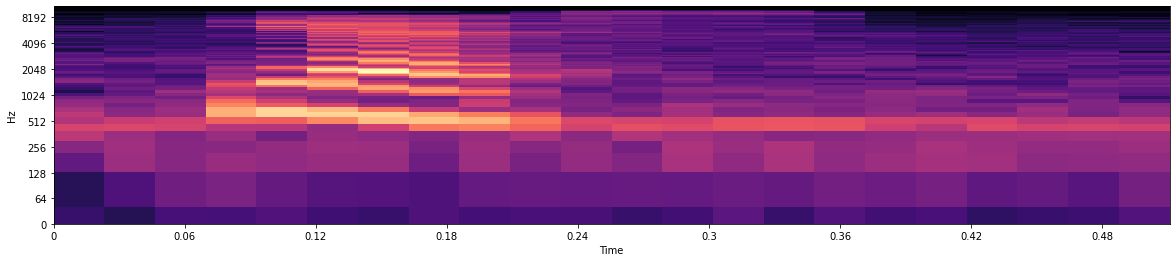

In [230]:
plt.figure(figsize=(20, 4))
librosa.display.specshow(mel_spect, y_axis='log', x_axis='time')

In [231]:
sf.write('tone.wav', data, sr)
ipd.Audio('tone.wav')

In [ ]:
len(data_1), len(data_2)

In [816]:
data_1 = np.expand_dims(data_1, 0)
data_2 = np.expand_dims(data_2, 0)

In [817]:
data = np.concatenate((data_1, data_2), axis=0)
data.shape

(2, 22050)

In [809]:
data = np.concatenate((data_1, data_2), axis=0)
data.shape

p_aug = {
    'gaussian': 1,
    'stretch': 0.3,
    'pitch_shift': 0.3,
    'shift': 0.5,
    'clipping': 0.3,
}
data = make_aug(data, sr, '../../spotter_data/_background_noise_', noise_to_data, 22050, p_aug)

1
pink_noise.wav 1323000


In [810]:
sf.write('tone.wav', data[0], sr)
ipd.Audio('tone.wav')

In [812]:
sf.write('tone.wav', data[1], sr)
ipd.Audio('tone.wav')

In [579]:
print(augmented_samples.shape)
augmented_samples[0].shape

(2, 22050)


(22050,)

In [845]:
def make_batch(df, lb, batch_size, wav_len, p_aug):
    words = df.sample(n=batch_size)
    X = None
    for batch_num in range(0, batch_size // 16):
        batch_df = df.sample(n=16)
        print(batch_df)
        temp = []
        for word_path in batch_df['path']:
            data, _ = librosa.load(word_path)
            data = np.expand_dims(data, 0)
            if len(data) > 22050:
                data = data[:, :22050]
            elif len(data) < 22050:
                b = np.zeros((1, 22050 - data.shape[1]))
                data = np.concatenate((data, b), axis=1)
            
            temp.append(data)
    X = np.concatenate(temp, axis=0)

In [851]:
a1 = np.array([[1, 2, 3]])
a2 = np.array([[3, 4, 5]])
a3 = np.array([[5, 6, 7]])
print(a1.shape, a2.shape, a3.shape)
X = None
X = np.concatenate(a1, axis = 0)
print(X)

(1, 3) (1, 3) (1, 3)
[1 2 3]


In [846]:
make_batch(df, None, 16, 22050, None)

       Unnamed: 0    word                                               path
51986       28304  unkown  /Users/mbassalaev/Desktop/spotter_data/marvin/...
28842        5160  unkown  /Users/mbassalaev/Desktop/spotter_data/tree/56...
23731          49  unkown  /Users/mbassalaev/Desktop/spotter_data/eight/a...
31514        7832  unkown  /Users/mbassalaev/Desktop/spotter_data/happy/5...
55609       31927  unkown  /Users/mbassalaev/Desktop/spotter_data/two/83f...
14518       14518      on  /Users/mbassalaev/Desktop/spotter_data/on/6cf5...
57017       33335  unkown  /Users/mbassalaev/Desktop/spotter_data/house/8...
42363       18681  unkown  /Users/mbassalaev/Desktop/spotter_data/sheila/...
491           491     yes  /Users/mbassalaev/Desktop/spotter_data/yes/9aa...
46326       22644  unkown  /Users/mbassalaev/Desktop/spotter_data/bird/d9...
51573       27891  unkown  /Users/mbassalaev/Desktop/spotter_data/seven/4...
60561       36879  unkown  /Users/mbassalaev/Desktop/spotter_data/five/ab...

In [306]:
df

,Unnamed: 0,word,path
0,0,yes,/Users/mbassalaev/Desktop/spotter_data/yes/988...
1,1,yes,/Users/mbassalaev/Desktop/spotter_data/yes/93e...
2,2,yes,/Users/mbassalaev/Desktop/spotter_data/yes/a75...
3,3,yes,/Users/mbassalaev/Desktop/spotter_data/yes/627...
4,4,yes,/Users/mbassalaev/Desktop/spotter_data/yes/439...
...,...,...,...
64716,41034,unkown,/Users/mbassalaev/Desktop/spotter_data/four/93...
64717,41035,unkown,/Users/mbassalaev/Desktop/spotter_data/four/0c...
64718,41036,unkown,/Users/mbassalaev/Desktop/spotter_data/four/23...
64719,41037,unkown,/Users/mbassalaev/Desktop/spotter_data/four/17...


In [307]:
make_batch(df, None, 3)

['/Users/mbassalaev/Desktop/spotter_data/right/3a33d3a4_nohash_2.wav', '/Users/mbassalaev/Desktop/spotter_data/six/2bfe70ef_nohash_1.wav', '/Users/mbassalaev/Desktop/spotter_data/no/8e05039f_nohash_0.wav'] ['right', 'unkown', 'no']
